### Загрузка модулей и данных

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import random
import matplotlib.pyplot as plt
from warnings import filterwarnings
plt.style.use('dark_background')
filterwarnings('ignore')

import torchtext.data as data
from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import spacy
spacy.load("en_core_web_sm")
from sklearn.model_selection import train_test_split
from scipy. stats import pearsonr
from gensim.utils import simple_preprocess
import gensim
# Чтение данных и удаление пустых значений
df = pd.read_csv('FakeNewsNet.csv', encoding='utf-8', usecols=['title', 'news_url', 'source_domain', 'real'])

# сразу удаляем все NULL-значения
a = df.shape[0]
df = df.dropna(how='any', axis=0)
print(f'Удалено строк с пропущенными значениями: {a-df.shape[0]}\n')

# Проверка дисбаланса данных
print("Баланс классов:")
print(df.real.value_counts())
df.head()

Удалено строк с пропущенными значениями: 330

Баланс классов:
1    17371
0     5495
Name: real, dtype: int64


,title,news_url,source_domain,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,1


In [2]:
#комбинируем текст
df['text'] = df.apply(lambda x: x['title']+' '+x['news_url']+' '+x['source_domain'], axis=1)
result_df = df[['text', 'real']].copy()
result_df.head()

,text,real
0,Kandi Burruss Explodes Over Rape Accusation on...,1
1,People's Choice Awards 2018: The best red carp...,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,1
3,Colombian singer Maluma sparks rumours of inap...,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,1


In [3]:
# Определите поля (fields)
TEXT = data.Field(sequential=True, tokenize='spacy', lower=True, tokenizer_language='en_core_web_sm')
LABEL = data.LabelField(dtype=torch.float)

In [4]:
# Создайте список примеров
examples = []
for index, row in df.iterrows():
    text = row['text']
    label = row['real']
    examples.append(data.Example.fromlist([text, label], fields=[('text', TEXT), ('label', LABEL)]))

In [5]:
# Создайте Dataset
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

In [6]:
# Задайте seed для воспроизводимости
SEED = 42
random.seed(SEED)

# Разбейте на тренировочный и тестовый наборы данных
train_data, test_data = dataset.split(split_ratio=0.8, random_state=random.seed(SEED))

In [7]:
# Построение словаря
VOCAB_SIZE = 30000
TEXT.build_vocab(train_data, max_size=VOCAB_SIZE)
LABEL.build_vocab(train_data)

In [8]:
# Определение BATCH_SIZE и указание, что при наличии GPU вычисления будут выполняться на нём
BATCH_SIZE = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Создаём итератор
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_within_batch=True,
    sort_key=lambda x: len(x.text))

### Word 2 Vec

In [10]:
#
from gensim.utils import simple_preprocess

W2V_SIZE = 160
W2V_WINDOW = 7
W2V_EPOCH = 100
W2V_MIN_COUNT = 2

df['preprocessed_text'] = df['text'].apply(lambda x: simple_preprocess(x))

documents = df['text'].tolist()
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE,sg=0,window=W2V_WINDOW ,min_count=W2V_MIN_COUNT)
w2v_model.build_vocab(df['preprocessed_text'], progress_per=10000)
w2v_model.train(df['preprocessed_text'], total_examples=len(df['preprocessed_text']), epochs=W2V_EPOCH)
w2v_model.save('w2v_model.txt')
# w2v_model = gensim.models.word2vec.Word2Vec.load('...txt')

pre_trained_emb = torch.FloatTensor(w2v_model.wv.vectors)
embedding = nn.Embedding.from_pretrained(pre_trained_emb)

In [11]:
import numpy as np
word2vec_vectors = []

for token, idx in TEXT.vocab.stoi.items():
    if token in w2v_model.wv.key_to_index.keys():
        word2vec_vectors.append(torch.FloatTensor(w2v_model.wv.get_vector(token)))
    else:
        word2vec_vectors.append(torch.zeros(W2V_SIZE))
        
TEXT.vocab.set_vectors(TEXT.vocab.stoi, word2vec_vectors, W2V_SIZE)
pre_trained_emb = torch.FloatTensor(TEXT.vocab.vectors)

embeddings = nn.Embedding.from_pretrained(pre_trained_emb)
embeddings

Embedding(30002, 160)

### Модель RNN

In [22]:
# Определяем RNN модель
class GruClassifier(nn.Module):
    
    def __init__(self, hidden_size, output_size, embedding_dim, pretrained_embeddings, n_layers, dropout):    
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings)
        self.gru = nn.GRU(embedding_dim, hidden_size, n_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.gru(embedded)
        hidden = hidden[0]
        hidden = self.dropout(hidden)
        output = torch.sigmoid(self.fc(hidden.squeeze(0)))
        return output

In [23]:
# Определяем параметры модели
embedding_dim = W2V_SIZE
hidden_size = 256
output_size = 1
n_layers = 1
dropout_ = 0.5

In [24]:
model_gru = GruClassifier(hidden_size, output_size, embedding_dim, pre_trained_emb, n_layers, dropout_)

In [25]:
# Определяем оптимизатор и функцию потерь
optimizer = optim.Adam(model_gru.parameters(), lr=0.00001)
criterion = nn.BCEWithLogitsLoss()

In [26]:
model_gru = model_gru.to(device)
criterion = criterion.to(device)

In [27]:
# Вычисляем accuracy
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [28]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    all_predictions = []
    all_labels = []

    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

        all_predictions += predictions.tolist()
        all_labels += batch.label.tolist()

    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)
    val_acc = binary_accuracy(all_predictions, all_labels)
    val_loss = criterion(all_predictions, all_labels).item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), val_loss, val_acc.item()

In [29]:
N_EPOCHS = 250

In [30]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in tqdm(range(N_EPOCHS)):
    train_loss, train_acc, val_loss, val_acc = train(model_gru, train_iterator, optimizer, criterion)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc*100:.2f}%')

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)


  0%|▎                                                                                 | 1/250 [00:01<07:09,  1.73s/it]

Epoch: 01, Train Loss: 0.828, Train Acc: 24.16%, Val Loss: 0.828, Val Acc: 24.15%


  1%|▋                                                                                 | 2/250 [00:03<06:07,  1.48s/it]

Epoch: 02, Train Loss: 0.714, Train Acc: 24.15%, Val Loss: 0.714, Val Acc: 24.15%


  1%|▉                                                                                 | 3/250 [00:04<05:54,  1.43s/it]

Epoch: 03, Train Loss: 0.694, Train Acc: 24.15%, Val Loss: 0.694, Val Acc: 24.15%


  2%|█▎                                                                                | 4/250 [00:05<05:43,  1.40s/it]

Epoch: 04, Train Loss: 0.690, Train Acc: 24.15%, Val Loss: 0.690, Val Acc: 24.15%


  2%|█▋                                                                                | 5/250 [00:07<05:35,  1.37s/it]

Epoch: 05, Train Loss: 0.685, Train Acc: 24.15%, Val Loss: 0.685, Val Acc: 24.15%


  2%|█▉                                                                                | 6/250 [00:08<05:32,  1.36s/it]

Epoch: 06, Train Loss: 0.680, Train Acc: 24.15%, Val Loss: 0.680, Val Acc: 24.15%


  3%|██▎                                                                               | 7/250 [00:09<05:28,  1.35s/it]

Epoch: 07, Train Loss: 0.677, Train Acc: 24.15%, Val Loss: 0.677, Val Acc: 24.15%


  3%|██▌                                                                               | 8/250 [00:11<05:26,  1.35s/it]

Epoch: 08, Train Loss: 0.675, Train Acc: 24.15%, Val Loss: 0.675, Val Acc: 24.15%


  4%|██▉                                                                               | 9/250 [00:12<05:25,  1.35s/it]

Epoch: 09, Train Loss: 0.674, Train Acc: 24.15%, Val Loss: 0.674, Val Acc: 24.15%


  4%|███▏                                                                             | 10/250 [00:13<05:23,  1.35s/it]

Epoch: 10, Train Loss: 0.673, Train Acc: 24.15%, Val Loss: 0.673, Val Acc: 24.15%


  4%|███▌                                                                             | 11/250 [00:15<05:22,  1.35s/it]

Epoch: 11, Train Loss: 0.672, Train Acc: 24.15%, Val Loss: 0.672, Val Acc: 24.15%


  5%|███▉                                                                             | 12/250 [00:16<05:21,  1.35s/it]

Epoch: 12, Train Loss: 0.671, Train Acc: 24.15%, Val Loss: 0.671, Val Acc: 24.15%


  5%|████▏                                                                            | 13/250 [00:17<05:19,  1.35s/it]

Epoch: 13, Train Loss: 0.671, Train Acc: 24.16%, Val Loss: 0.671, Val Acc: 24.15%


  6%|████▌                                                                            | 14/250 [00:19<05:22,  1.37s/it]

Epoch: 14, Train Loss: 0.670, Train Acc: 24.15%, Val Loss: 0.670, Val Acc: 24.15%


  6%|████▊                                                                            | 15/250 [00:20<05:20,  1.37s/it]

Epoch: 15, Train Loss: 0.670, Train Acc: 24.15%, Val Loss: 0.670, Val Acc: 24.15%


  6%|█████▏                                                                           | 16/250 [00:21<05:20,  1.37s/it]

Epoch: 16, Train Loss: 0.669, Train Acc: 24.15%, Val Loss: 0.669, Val Acc: 24.15%


  7%|█████▌                                                                           | 17/250 [00:23<05:20,  1.38s/it]

Epoch: 17, Train Loss: 0.669, Train Acc: 24.15%, Val Loss: 0.669, Val Acc: 24.15%


  7%|█████▊                                                                           | 18/250 [00:24<05:20,  1.38s/it]

Epoch: 18, Train Loss: 0.668, Train Acc: 24.15%, Val Loss: 0.668, Val Acc: 24.15%


  8%|██████▏                                                                          | 19/250 [00:26<05:20,  1.39s/it]

Epoch: 19, Train Loss: 0.668, Train Acc: 24.15%, Val Loss: 0.668, Val Acc: 24.15%


  8%|██████▍                                                                          | 20/250 [00:27<05:16,  1.37s/it]

Epoch: 20, Train Loss: 0.668, Train Acc: 24.15%, Val Loss: 0.668, Val Acc: 24.15%


  8%|██████▊                                                                          | 21/250 [00:28<05:11,  1.36s/it]

Epoch: 21, Train Loss: 0.667, Train Acc: 24.15%, Val Loss: 0.667, Val Acc: 24.15%


  9%|███████▏                                                                         | 22/250 [00:30<05:10,  1.36s/it]

Epoch: 22, Train Loss: 0.667, Train Acc: 24.18%, Val Loss: 0.667, Val Acc: 24.18%


  9%|███████▍                                                                         | 23/250 [00:31<05:08,  1.36s/it]

Epoch: 23, Train Loss: 0.666, Train Acc: 24.25%, Val Loss: 0.666, Val Acc: 24.27%


 10%|███████▊                                                                         | 24/250 [00:32<05:06,  1.35s/it]

Epoch: 24, Train Loss: 0.666, Train Acc: 24.42%, Val Loss: 0.666, Val Acc: 24.52%


 10%|████████                                                                         | 25/250 [00:34<05:04,  1.35s/it]

Epoch: 25, Train Loss: 0.666, Train Acc: 24.72%, Val Loss: 0.666, Val Acc: 24.95%


 10%|████████▍                                                                        | 26/250 [00:35<05:02,  1.35s/it]

Epoch: 26, Train Loss: 0.665, Train Acc: 25.47%, Val Loss: 0.665, Val Acc: 25.69%


 11%|████████▋                                                                        | 27/250 [00:36<04:59,  1.34s/it]

Epoch: 27, Train Loss: 0.665, Train Acc: 26.52%, Val Loss: 0.665, Val Acc: 26.94%


 11%|█████████                                                                        | 28/250 [00:38<04:58,  1.34s/it]

Epoch: 28, Train Loss: 0.665, Train Acc: 28.44%, Val Loss: 0.665, Val Acc: 29.04%


 12%|█████████▍                                                                       | 29/250 [00:39<04:57,  1.35s/it]

Epoch: 29, Train Loss: 0.664, Train Acc: 30.81%, Val Loss: 0.664, Val Acc: 31.71%


 12%|█████████▋                                                                       | 30/250 [00:40<04:56,  1.35s/it]

Epoch: 30, Train Loss: 0.664, Train Acc: 34.51%, Val Loss: 0.664, Val Acc: 35.50%


 12%|██████████                                                                       | 31/250 [00:42<04:54,  1.34s/it]

Epoch: 31, Train Loss: 0.664, Train Acc: 39.20%, Val Loss: 0.664, Val Acc: 40.45%


 13%|██████████▎                                                                      | 32/250 [00:43<04:52,  1.34s/it]

Epoch: 32, Train Loss: 0.663, Train Acc: 43.47%, Val Loss: 0.663, Val Acc: 44.86%


 13%|██████████▋                                                                      | 33/250 [00:44<04:51,  1.34s/it]

Epoch: 33, Train Loss: 0.663, Train Acc: 48.79%, Val Loss: 0.663, Val Acc: 50.18%


 14%|███████████                                                                      | 34/250 [00:46<04:50,  1.34s/it]

Epoch: 34, Train Loss: 0.663, Train Acc: 52.99%, Val Loss: 0.663, Val Acc: 54.21%


 14%|███████████▎                                                                     | 35/250 [00:47<04:48,  1.34s/it]

Epoch: 35, Train Loss: 0.663, Train Acc: 57.67%, Val Loss: 0.663, Val Acc: 58.82%


 14%|███████████▋                                                                     | 36/250 [00:49<04:46,  1.34s/it]

Epoch: 36, Train Loss: 0.662, Train Acc: 60.92%, Val Loss: 0.662, Val Acc: 61.99%


 15%|███████████▉                                                                     | 37/250 [00:50<04:48,  1.35s/it]

Epoch: 37, Train Loss: 0.662, Train Acc: 64.29%, Val Loss: 0.662, Val Acc: 65.11%


 15%|████████████▎                                                                    | 38/250 [00:51<04:51,  1.37s/it]

Epoch: 38, Train Loss: 0.662, Train Acc: 67.11%, Val Loss: 0.662, Val Acc: 67.94%


 16%|████████████▋                                                                    | 39/250 [00:53<04:49,  1.37s/it]

Epoch: 39, Train Loss: 0.662, Train Acc: 69.56%, Val Loss: 0.662, Val Acc: 70.19%


 16%|████████████▉                                                                    | 40/250 [00:54<04:53,  1.40s/it]

Epoch: 40, Train Loss: 0.662, Train Acc: 70.61%, Val Loss: 0.662, Val Acc: 71.34%


 16%|█████████████▎                                                                   | 41/250 [00:55<04:46,  1.37s/it]

Epoch: 41, Train Loss: 0.661, Train Acc: 72.48%, Val Loss: 0.661, Val Acc: 72.98%


 17%|█████████████▌                                                                   | 42/250 [00:57<04:42,  1.36s/it]

Epoch: 42, Train Loss: 0.661, Train Acc: 73.36%, Val Loss: 0.661, Val Acc: 73.68%


 17%|█████████████▉                                                                   | 43/250 [00:58<04:38,  1.35s/it]

Epoch: 43, Train Loss: 0.661, Train Acc: 74.91%, Val Loss: 0.661, Val Acc: 75.18%


 18%|██████████████▎                                                                  | 44/250 [00:59<04:36,  1.34s/it]

Epoch: 44, Train Loss: 0.661, Train Acc: 75.27%, Val Loss: 0.661, Val Acc: 75.54%


 18%|██████████████▌                                                                  | 45/250 [01:01<04:34,  1.34s/it]

Epoch: 45, Train Loss: 0.661, Train Acc: 75.83%, Val Loss: 0.661, Val Acc: 75.99%


 18%|██████████████▉                                                                  | 46/250 [01:02<04:30,  1.33s/it]

Epoch: 46, Train Loss: 0.660, Train Acc: 76.42%, Val Loss: 0.660, Val Acc: 76.58%


 19%|███████████████▏                                                                 | 47/250 [01:03<04:29,  1.33s/it]

Epoch: 47, Train Loss: 0.660, Train Acc: 76.79%, Val Loss: 0.660, Val Acc: 76.94%


 19%|███████████████▌                                                                 | 48/250 [01:05<04:26,  1.32s/it]

Epoch: 48, Train Loss: 0.660, Train Acc: 77.40%, Val Loss: 0.660, Val Acc: 77.54%


 20%|███████████████▉                                                                 | 49/250 [01:06<04:25,  1.32s/it]

Epoch: 49, Train Loss: 0.660, Train Acc: 77.77%, Val Loss: 0.660, Val Acc: 77.82%


 20%|████████████████▏                                                                | 50/250 [01:07<04:23,  1.32s/it]

Epoch: 50, Train Loss: 0.660, Train Acc: 78.22%, Val Loss: 0.660, Val Acc: 78.31%


 20%|████████████████▌                                                                | 51/250 [01:09<04:23,  1.32s/it]

Epoch: 51, Train Loss: 0.660, Train Acc: 78.45%, Val Loss: 0.660, Val Acc: 78.60%


 21%|████████████████▊                                                                | 52/250 [01:10<04:21,  1.32s/it]

Epoch: 52, Train Loss: 0.660, Train Acc: 78.63%, Val Loss: 0.660, Val Acc: 78.72%


 21%|█████████████████▏                                                               | 53/250 [01:11<04:19,  1.32s/it]

Epoch: 53, Train Loss: 0.660, Train Acc: 78.86%, Val Loss: 0.660, Val Acc: 78.93%


 22%|█████████████████▍                                                               | 54/250 [01:13<04:18,  1.32s/it]

Epoch: 54, Train Loss: 0.659, Train Acc: 78.97%, Val Loss: 0.659, Val Acc: 79.08%


 22%|█████████████████▊                                                               | 55/250 [01:14<04:16,  1.32s/it]

Epoch: 55, Train Loss: 0.659, Train Acc: 78.96%, Val Loss: 0.659, Val Acc: 79.07%


 22%|██████████████████▏                                                              | 56/250 [01:15<04:15,  1.32s/it]

Epoch: 56, Train Loss: 0.659, Train Acc: 79.32%, Val Loss: 0.659, Val Acc: 79.39%


 23%|██████████████████▍                                                              | 57/250 [01:17<04:14,  1.32s/it]

Epoch: 57, Train Loss: 0.659, Train Acc: 79.43%, Val Loss: 0.659, Val Acc: 79.49%


 23%|██████████████████▊                                                              | 58/250 [01:18<04:11,  1.31s/it]

Epoch: 58, Train Loss: 0.659, Train Acc: 79.64%, Val Loss: 0.659, Val Acc: 79.69%


 24%|███████████████████                                                              | 59/250 [01:19<04:09,  1.31s/it]

Epoch: 59, Train Loss: 0.659, Train Acc: 79.77%, Val Loss: 0.659, Val Acc: 79.82%


 24%|███████████████████▍                                                             | 60/250 [01:20<04:08,  1.31s/it]

Epoch: 60, Train Loss: 0.659, Train Acc: 79.95%, Val Loss: 0.659, Val Acc: 79.98%


 24%|███████████████████▊                                                             | 61/250 [01:22<04:07,  1.31s/it]

Epoch: 61, Train Loss: 0.659, Train Acc: 79.92%, Val Loss: 0.659, Val Acc: 79.98%


 25%|████████████████████                                                             | 62/250 [01:23<04:05,  1.31s/it]

Epoch: 62, Train Loss: 0.659, Train Acc: 79.98%, Val Loss: 0.659, Val Acc: 80.00%


 25%|████████████████████▍                                                            | 63/250 [01:24<04:03,  1.30s/it]

Epoch: 63, Train Loss: 0.659, Train Acc: 80.08%, Val Loss: 0.659, Val Acc: 80.15%


 26%|████████████████████▋                                                            | 64/250 [01:26<04:02,  1.30s/it]

Epoch: 64, Train Loss: 0.659, Train Acc: 80.10%, Val Loss: 0.659, Val Acc: 80.12%


 26%|█████████████████████                                                            | 65/250 [01:27<04:03,  1.32s/it]

Epoch: 65, Train Loss: 0.659, Train Acc: 80.49%, Val Loss: 0.659, Val Acc: 80.53%


 26%|█████████████████████▍                                                           | 66/250 [01:28<04:05,  1.33s/it]

Epoch: 66, Train Loss: 0.658, Train Acc: 80.36%, Val Loss: 0.658, Val Acc: 80.40%


 27%|█████████████████████▋                                                           | 67/250 [01:30<04:02,  1.33s/it]

Epoch: 67, Train Loss: 0.658, Train Acc: 80.49%, Val Loss: 0.658, Val Acc: 80.53%


 27%|██████████████████████                                                           | 68/250 [01:31<03:59,  1.32s/it]

Epoch: 68, Train Loss: 0.658, Train Acc: 80.50%, Val Loss: 0.658, Val Acc: 80.52%


 28%|██████████████████████▎                                                          | 69/250 [01:32<03:58,  1.32s/it]

Epoch: 69, Train Loss: 0.658, Train Acc: 80.57%, Val Loss: 0.658, Val Acc: 80.59%


 28%|██████████████████████▋                                                          | 70/250 [01:34<03:57,  1.32s/it]

Epoch: 70, Train Loss: 0.658, Train Acc: 80.70%, Val Loss: 0.658, Val Acc: 80.71%


 28%|███████████████████████                                                          | 71/250 [01:35<03:55,  1.32s/it]

Epoch: 71, Train Loss: 0.658, Train Acc: 80.94%, Val Loss: 0.658, Val Acc: 80.95%


 29%|███████████████████████▎                                                         | 72/250 [01:36<03:56,  1.33s/it]

Epoch: 72, Train Loss: 0.658, Train Acc: 80.69%, Val Loss: 0.658, Val Acc: 80.71%


 29%|███████████████████████▋                                                         | 73/250 [01:38<03:55,  1.33s/it]

Epoch: 73, Train Loss: 0.658, Train Acc: 80.85%, Val Loss: 0.658, Val Acc: 80.89%


 30%|███████████████████████▉                                                         | 74/250 [01:39<03:55,  1.34s/it]

Epoch: 74, Train Loss: 0.658, Train Acc: 80.91%, Val Loss: 0.658, Val Acc: 80.97%


 30%|████████████████████████▎                                                        | 75/250 [01:40<03:54,  1.34s/it]

Epoch: 75, Train Loss: 0.658, Train Acc: 80.98%, Val Loss: 0.658, Val Acc: 81.05%


 30%|████████████████████████▌                                                        | 76/250 [01:42<03:52,  1.34s/it]

Epoch: 76, Train Loss: 0.658, Train Acc: 81.19%, Val Loss: 0.658, Val Acc: 81.22%


 31%|████████████████████████▉                                                        | 77/250 [01:43<03:50,  1.33s/it]

Epoch: 77, Train Loss: 0.658, Train Acc: 81.12%, Val Loss: 0.658, Val Acc: 81.14%


 31%|█████████████████████████▎                                                       | 78/250 [01:44<03:49,  1.33s/it]

Epoch: 78, Train Loss: 0.658, Train Acc: 81.22%, Val Loss: 0.658, Val Acc: 81.24%


 32%|█████████████████████████▌                                                       | 79/250 [01:46<03:47,  1.33s/it]

Epoch: 79, Train Loss: 0.658, Train Acc: 81.25%, Val Loss: 0.658, Val Acc: 81.28%


 32%|█████████████████████████▉                                                       | 80/250 [01:47<03:45,  1.33s/it]

Epoch: 80, Train Loss: 0.657, Train Acc: 81.30%, Val Loss: 0.657, Val Acc: 81.36%


 32%|██████████████████████████▏                                                      | 81/250 [01:48<03:43,  1.33s/it]

Epoch: 81, Train Loss: 0.658, Train Acc: 81.43%, Val Loss: 0.658, Val Acc: 81.44%


 33%|██████████████████████████▌                                                      | 82/250 [01:50<03:42,  1.32s/it]

Epoch: 82, Train Loss: 0.657, Train Acc: 81.43%, Val Loss: 0.657, Val Acc: 81.43%


 33%|██████████████████████████▉                                                      | 83/250 [01:51<03:40,  1.32s/it]

Epoch: 83, Train Loss: 0.657, Train Acc: 81.58%, Val Loss: 0.657, Val Acc: 81.59%


 34%|███████████████████████████▏                                                     | 84/250 [01:52<03:39,  1.32s/it]

Epoch: 84, Train Loss: 0.657, Train Acc: 81.60%, Val Loss: 0.657, Val Acc: 81.64%


 34%|███████████████████████████▌                                                     | 85/250 [01:54<03:38,  1.32s/it]

Epoch: 85, Train Loss: 0.657, Train Acc: 81.46%, Val Loss: 0.657, Val Acc: 81.51%


 34%|███████████████████████████▊                                                     | 86/250 [01:55<03:35,  1.32s/it]

Epoch: 86, Train Loss: 0.657, Train Acc: 81.48%, Val Loss: 0.657, Val Acc: 81.51%


 35%|████████████████████████████▏                                                    | 87/250 [01:56<03:33,  1.31s/it]

Epoch: 87, Train Loss: 0.657, Train Acc: 81.58%, Val Loss: 0.657, Val Acc: 81.63%


 35%|████████████████████████████▌                                                    | 88/250 [01:57<03:31,  1.31s/it]

Epoch: 88, Train Loss: 0.657, Train Acc: 81.61%, Val Loss: 0.657, Val Acc: 81.65%


 36%|████████████████████████████▊                                                    | 89/250 [01:59<03:31,  1.31s/it]

Epoch: 89, Train Loss: 0.657, Train Acc: 81.62%, Val Loss: 0.657, Val Acc: 81.67%


 36%|█████████████████████████████▏                                                   | 90/250 [02:00<03:30,  1.31s/it]

Epoch: 90, Train Loss: 0.657, Train Acc: 81.64%, Val Loss: 0.657, Val Acc: 81.67%


 36%|█████████████████████████████▍                                                   | 91/250 [02:01<03:28,  1.31s/it]

Epoch: 91, Train Loss: 0.657, Train Acc: 81.75%, Val Loss: 0.657, Val Acc: 81.75%


 37%|█████████████████████████████▊                                                   | 92/250 [02:03<03:27,  1.31s/it]

Epoch: 92, Train Loss: 0.657, Train Acc: 81.82%, Val Loss: 0.657, Val Acc: 81.84%


 37%|██████████████████████████████▏                                                  | 93/250 [02:04<03:25,  1.31s/it]

Epoch: 93, Train Loss: 0.657, Train Acc: 82.04%, Val Loss: 0.657, Val Acc: 82.06%


 38%|██████████████████████████████▍                                                  | 94/250 [02:05<03:24,  1.31s/it]

Epoch: 94, Train Loss: 0.657, Train Acc: 81.82%, Val Loss: 0.657, Val Acc: 81.87%


 38%|██████████████████████████████▊                                                  | 95/250 [02:07<03:22,  1.31s/it]

Epoch: 95, Train Loss: 0.657, Train Acc: 81.93%, Val Loss: 0.657, Val Acc: 81.93%


 38%|███████████████████████████████                                                  | 96/250 [02:08<03:21,  1.31s/it]

Epoch: 96, Train Loss: 0.657, Train Acc: 82.03%, Val Loss: 0.657, Val Acc: 82.05%


 39%|███████████████████████████████▍                                                 | 97/250 [02:09<03:21,  1.31s/it]

Epoch: 97, Train Loss: 0.657, Train Acc: 81.87%, Val Loss: 0.657, Val Acc: 81.91%


 39%|███████████████████████████████▊                                                 | 98/250 [02:11<03:20,  1.32s/it]

Epoch: 98, Train Loss: 0.657, Train Acc: 81.93%, Val Loss: 0.657, Val Acc: 81.95%


 40%|████████████████████████████████                                                 | 99/250 [02:12<03:19,  1.32s/it]

Epoch: 99, Train Loss: 0.657, Train Acc: 81.87%, Val Loss: 0.657, Val Acc: 81.88%


 40%|████████████████████████████████                                                | 100/250 [02:13<03:17,  1.32s/it]

Epoch: 100, Train Loss: 0.657, Train Acc: 82.02%, Val Loss: 0.657, Val Acc: 82.05%


 40%|████████████████████████████████▎                                               | 101/250 [02:15<03:16,  1.32s/it]

Epoch: 101, Train Loss: 0.657, Train Acc: 82.06%, Val Loss: 0.657, Val Acc: 82.05%


 41%|████████████████████████████████▋                                               | 102/250 [02:16<03:15,  1.32s/it]

Epoch: 102, Train Loss: 0.657, Train Acc: 82.30%, Val Loss: 0.657, Val Acc: 82.30%


 41%|████████████████████████████████▉                                               | 103/250 [02:17<03:14,  1.32s/it]

Epoch: 103, Train Loss: 0.656, Train Acc: 82.25%, Val Loss: 0.656, Val Acc: 82.26%


 42%|█████████████████████████████████▎                                              | 104/250 [02:19<03:13,  1.32s/it]

Epoch: 104, Train Loss: 0.656, Train Acc: 82.30%, Val Loss: 0.656, Val Acc: 82.32%


 42%|█████████████████████████████████▌                                              | 105/250 [02:20<03:10,  1.32s/it]

Epoch: 105, Train Loss: 0.656, Train Acc: 82.21%, Val Loss: 0.656, Val Acc: 82.22%


 42%|█████████████████████████████████▉                                              | 106/250 [02:21<03:09,  1.32s/it]

Epoch: 106, Train Loss: 0.656, Train Acc: 82.25%, Val Loss: 0.656, Val Acc: 82.27%


 43%|██████████████████████████████████▏                                             | 107/250 [02:22<03:07,  1.31s/it]

Epoch: 107, Train Loss: 0.656, Train Acc: 82.25%, Val Loss: 0.656, Val Acc: 82.28%


 43%|██████████████████████████████████▌                                             | 108/250 [02:24<03:07,  1.32s/it]

Epoch: 108, Train Loss: 0.657, Train Acc: 82.37%, Val Loss: 0.657, Val Acc: 82.40%


 44%|██████████████████████████████████▉                                             | 109/250 [02:25<03:05,  1.32s/it]

Epoch: 109, Train Loss: 0.656, Train Acc: 82.31%, Val Loss: 0.656, Val Acc: 82.32%


 44%|███████████████████████████████████▏                                            | 110/250 [02:26<03:03,  1.31s/it]

Epoch: 110, Train Loss: 0.656, Train Acc: 82.24%, Val Loss: 0.656, Val Acc: 82.24%


 44%|███████████████████████████████████▌                                            | 111/250 [02:28<03:02,  1.31s/it]

Epoch: 111, Train Loss: 0.657, Train Acc: 82.39%, Val Loss: 0.657, Val Acc: 82.40%


 45%|███████████████████████████████████▊                                            | 112/250 [02:29<03:02,  1.32s/it]

Epoch: 112, Train Loss: 0.656, Train Acc: 82.44%, Val Loss: 0.656, Val Acc: 82.46%


 45%|████████████████████████████████████▏                                           | 113/250 [02:30<03:00,  1.32s/it]

Epoch: 113, Train Loss: 0.656, Train Acc: 82.52%, Val Loss: 0.656, Val Acc: 82.54%


 46%|████████████████████████████████████▍                                           | 114/250 [02:32<02:59,  1.32s/it]

Epoch: 114, Train Loss: 0.656, Train Acc: 82.47%, Val Loss: 0.656, Val Acc: 82.55%


 46%|████████████████████████████████████▊                                           | 115/250 [02:33<02:58,  1.32s/it]

Epoch: 115, Train Loss: 0.656, Train Acc: 82.54%, Val Loss: 0.656, Val Acc: 82.57%


 46%|█████████████████████████████████████                                           | 116/250 [02:34<02:57,  1.33s/it]

Epoch: 116, Train Loss: 0.656, Train Acc: 82.56%, Val Loss: 0.656, Val Acc: 82.55%


 47%|█████████████████████████████████████▍                                          | 117/250 [02:36<02:56,  1.33s/it]

Epoch: 117, Train Loss: 0.656, Train Acc: 82.46%, Val Loss: 0.656, Val Acc: 82.48%


 47%|█████████████████████████████████████▊                                          | 118/250 [02:37<02:55,  1.33s/it]

Epoch: 118, Train Loss: 0.656, Train Acc: 82.77%, Val Loss: 0.656, Val Acc: 82.79%


 48%|██████████████████████████████████████                                          | 119/250 [02:38<02:53,  1.33s/it]

Epoch: 119, Train Loss: 0.656, Train Acc: 82.64%, Val Loss: 0.656, Val Acc: 82.66%


 48%|██████████████████████████████████████▍                                         | 120/250 [02:40<02:52,  1.33s/it]

Epoch: 120, Train Loss: 0.656, Train Acc: 82.61%, Val Loss: 0.656, Val Acc: 82.64%


 48%|██████████████████████████████████████▋                                         | 121/250 [02:41<02:50,  1.32s/it]

Epoch: 121, Train Loss: 0.656, Train Acc: 82.64%, Val Loss: 0.656, Val Acc: 82.64%


 49%|███████████████████████████████████████                                         | 122/250 [02:42<02:49,  1.32s/it]

Epoch: 122, Train Loss: 0.656, Train Acc: 82.64%, Val Loss: 0.656, Val Acc: 82.67%


 49%|███████████████████████████████████████▎                                        | 123/250 [02:44<02:48,  1.33s/it]

Epoch: 123, Train Loss: 0.656, Train Acc: 82.70%, Val Loss: 0.656, Val Acc: 82.73%


 50%|███████████████████████████████████████▋                                        | 124/250 [02:45<02:46,  1.32s/it]

Epoch: 124, Train Loss: 0.656, Train Acc: 82.87%, Val Loss: 0.656, Val Acc: 82.90%


 50%|████████████████████████████████████████                                        | 125/250 [02:46<02:44,  1.32s/it]

Epoch: 125, Train Loss: 0.657, Train Acc: 82.95%, Val Loss: 0.657, Val Acc: 82.97%


 50%|████████████████████████████████████████▎                                       | 126/250 [02:48<02:43,  1.32s/it]

Epoch: 126, Train Loss: 0.656, Train Acc: 82.73%, Val Loss: 0.656, Val Acc: 82.77%


 51%|████████████████████████████████████████▋                                       | 127/250 [02:49<02:42,  1.32s/it]

Epoch: 127, Train Loss: 0.656, Train Acc: 82.77%, Val Loss: 0.656, Val Acc: 82.80%


 51%|████████████████████████████████████████▉                                       | 128/250 [02:50<02:40,  1.32s/it]

Epoch: 128, Train Loss: 0.656, Train Acc: 82.81%, Val Loss: 0.656, Val Acc: 82.85%


 52%|█████████████████████████████████████████▎                                      | 129/250 [02:52<02:39,  1.32s/it]

Epoch: 129, Train Loss: 0.656, Train Acc: 83.11%, Val Loss: 0.656, Val Acc: 83.14%


 52%|█████████████████████████████████████████▌                                      | 130/250 [02:53<02:37,  1.31s/it]

Epoch: 130, Train Loss: 0.656, Train Acc: 82.86%, Val Loss: 0.656, Val Acc: 82.91%


 52%|█████████████████████████████████████████▉                                      | 131/250 [02:54<02:36,  1.32s/it]

Epoch: 131, Train Loss: 0.656, Train Acc: 82.83%, Val Loss: 0.656, Val Acc: 82.85%


 53%|██████████████████████████████████████████▏                                     | 132/250 [02:55<02:35,  1.31s/it]

Epoch: 132, Train Loss: 0.656, Train Acc: 82.91%, Val Loss: 0.656, Val Acc: 82.93%


 53%|██████████████████████████████████████████▌                                     | 133/250 [02:57<02:33,  1.31s/it]

Epoch: 133, Train Loss: 0.656, Train Acc: 82.90%, Val Loss: 0.656, Val Acc: 82.91%


 54%|██████████████████████████████████████████▉                                     | 134/250 [02:58<02:32,  1.32s/it]

Epoch: 134, Train Loss: 0.656, Train Acc: 83.00%, Val Loss: 0.656, Val Acc: 83.02%


 54%|███████████████████████████████████████████▏                                    | 135/250 [02:59<02:30,  1.31s/it]

Epoch: 135, Train Loss: 0.656, Train Acc: 83.09%, Val Loss: 0.656, Val Acc: 83.11%


 54%|███████████████████████████████████████████▌                                    | 136/250 [03:01<02:29,  1.31s/it]

Epoch: 136, Train Loss: 0.656, Train Acc: 83.13%, Val Loss: 0.656, Val Acc: 83.15%


 55%|███████████████████████████████████████████▊                                    | 137/250 [03:02<02:27,  1.30s/it]

Epoch: 137, Train Loss: 0.656, Train Acc: 83.08%, Val Loss: 0.656, Val Acc: 83.09%


 55%|████████████████████████████████████████████▏                                   | 138/250 [03:03<02:26,  1.30s/it]

Epoch: 138, Train Loss: 0.656, Train Acc: 83.18%, Val Loss: 0.656, Val Acc: 83.21%


 56%|████████████████████████████████████████████▍                                   | 139/250 [03:05<02:25,  1.31s/it]

Epoch: 139, Train Loss: 0.656, Train Acc: 83.10%, Val Loss: 0.656, Val Acc: 83.12%


 56%|████████████████████████████████████████████▊                                   | 140/250 [03:06<02:24,  1.32s/it]

Epoch: 140, Train Loss: 0.656, Train Acc: 83.04%, Val Loss: 0.656, Val Acc: 83.03%


 56%|█████████████████████████████████████████████                                   | 141/250 [03:07<02:22,  1.31s/it]

Epoch: 141, Train Loss: 0.656, Train Acc: 83.30%, Val Loss: 0.656, Val Acc: 83.32%


 57%|█████████████████████████████████████████████▍                                  | 142/250 [03:09<02:21,  1.31s/it]

Epoch: 142, Train Loss: 0.656, Train Acc: 83.06%, Val Loss: 0.656, Val Acc: 83.08%


 57%|█████████████████████████████████████████████▊                                  | 143/250 [03:10<02:20,  1.32s/it]

Epoch: 143, Train Loss: 0.656, Train Acc: 82.95%, Val Loss: 0.656, Val Acc: 83.02%


 58%|██████████████████████████████████████████████                                  | 144/250 [03:11<02:18,  1.31s/it]

Epoch: 144, Train Loss: 0.656, Train Acc: 83.18%, Val Loss: 0.656, Val Acc: 83.22%


 58%|██████████████████████████████████████████████▍                                 | 145/250 [03:13<02:17,  1.31s/it]

Epoch: 145, Train Loss: 0.656, Train Acc: 83.11%, Val Loss: 0.656, Val Acc: 83.12%


 58%|██████████████████████████████████████████████▋                                 | 146/250 [03:14<02:16,  1.31s/it]

Epoch: 146, Train Loss: 0.656, Train Acc: 83.17%, Val Loss: 0.656, Val Acc: 83.23%


 59%|███████████████████████████████████████████████                                 | 147/250 [03:15<02:16,  1.32s/it]

Epoch: 147, Train Loss: 0.656, Train Acc: 83.26%, Val Loss: 0.656, Val Acc: 83.31%


 59%|███████████████████████████████████████████████▎                                | 148/250 [03:16<02:14,  1.32s/it]

Epoch: 148, Train Loss: 0.656, Train Acc: 83.29%, Val Loss: 0.656, Val Acc: 83.34%


 60%|███████████████████████████████████████████████▋                                | 149/250 [03:18<02:13,  1.32s/it]

Epoch: 149, Train Loss: 0.656, Train Acc: 83.22%, Val Loss: 0.656, Val Acc: 83.26%


 60%|████████████████████████████████████████████████                                | 150/250 [03:19<02:12,  1.32s/it]

Epoch: 150, Train Loss: 0.656, Train Acc: 83.20%, Val Loss: 0.656, Val Acc: 83.23%


 60%|████████████████████████████████████████████████▎                               | 151/250 [03:20<02:11,  1.33s/it]

Epoch: 151, Train Loss: 0.656, Train Acc: 83.23%, Val Loss: 0.656, Val Acc: 83.24%


 61%|████████████████████████████████████████████████▋                               | 152/250 [03:22<02:08,  1.32s/it]

Epoch: 152, Train Loss: 0.656, Train Acc: 83.31%, Val Loss: 0.656, Val Acc: 83.35%


 61%|████████████████████████████████████████████████▉                               | 153/250 [03:23<02:07,  1.32s/it]

Epoch: 153, Train Loss: 0.656, Train Acc: 83.28%, Val Loss: 0.656, Val Acc: 83.29%


 62%|█████████████████████████████████████████████████▎                              | 154/250 [03:24<02:06,  1.32s/it]

Epoch: 154, Train Loss: 0.656, Train Acc: 83.37%, Val Loss: 0.656, Val Acc: 83.38%


 62%|█████████████████████████████████████████████████▌                              | 155/250 [03:26<02:05,  1.32s/it]

Epoch: 155, Train Loss: 0.656, Train Acc: 83.35%, Val Loss: 0.656, Val Acc: 83.37%


 62%|█████████████████████████████████████████████████▉                              | 156/250 [03:27<02:03,  1.32s/it]

Epoch: 156, Train Loss: 0.656, Train Acc: 83.46%, Val Loss: 0.656, Val Acc: 83.52%


 63%|██████████████████████████████████████████████████▏                             | 157/250 [03:28<02:02,  1.32s/it]

Epoch: 157, Train Loss: 0.656, Train Acc: 83.41%, Val Loss: 0.656, Val Acc: 83.41%


 63%|██████████████████████████████████████████████████▌                             | 158/250 [03:30<02:01,  1.32s/it]

Epoch: 158, Train Loss: 0.656, Train Acc: 83.54%, Val Loss: 0.656, Val Acc: 83.57%


 64%|██████████████████████████████████████████████████▉                             | 159/250 [03:31<02:01,  1.33s/it]

Epoch: 159, Train Loss: 0.656, Train Acc: 83.53%, Val Loss: 0.656, Val Acc: 83.56%


 64%|███████████████████████████████████████████████████▏                            | 160/250 [03:32<01:59,  1.33s/it]

Epoch: 160, Train Loss: 0.655, Train Acc: 83.62%, Val Loss: 0.655, Val Acc: 83.66%


 64%|███████████████████████████████████████████████████▌                            | 161/250 [03:34<01:58,  1.33s/it]

Epoch: 161, Train Loss: 0.656, Train Acc: 83.55%, Val Loss: 0.656, Val Acc: 83.59%


 65%|███████████████████████████████████████████████████▊                            | 162/250 [03:35<01:57,  1.33s/it]

Epoch: 162, Train Loss: 0.656, Train Acc: 83.63%, Val Loss: 0.656, Val Acc: 83.66%


 65%|████████████████████████████████████████████████████▏                           | 163/250 [03:36<01:55,  1.33s/it]

Epoch: 163, Train Loss: 0.656, Train Acc: 83.49%, Val Loss: 0.656, Val Acc: 83.52%


 66%|████████████████████████████████████████████████████▍                           | 164/250 [03:38<01:54,  1.33s/it]

Epoch: 164, Train Loss: 0.655, Train Acc: 83.61%, Val Loss: 0.655, Val Acc: 83.65%


 66%|████████████████████████████████████████████████████▊                           | 165/250 [03:39<01:52,  1.32s/it]

Epoch: 165, Train Loss: 0.656, Train Acc: 83.63%, Val Loss: 0.656, Val Acc: 83.67%


 66%|█████████████████████████████████████████████████████                           | 166/250 [03:40<01:51,  1.32s/it]

Epoch: 166, Train Loss: 0.656, Train Acc: 83.59%, Val Loss: 0.656, Val Acc: 83.61%


 67%|█████████████████████████████████████████████████████▍                          | 167/250 [03:42<01:49,  1.32s/it]

Epoch: 167, Train Loss: 0.655, Train Acc: 83.63%, Val Loss: 0.655, Val Acc: 83.63%


 67%|█████████████████████████████████████████████████████▊                          | 168/250 [03:43<01:48,  1.32s/it]

Epoch: 168, Train Loss: 0.655, Train Acc: 83.66%, Val Loss: 0.655, Val Acc: 83.68%


 68%|██████████████████████████████████████████████████████                          | 169/250 [03:44<01:47,  1.32s/it]

Epoch: 169, Train Loss: 0.655, Train Acc: 83.54%, Val Loss: 0.655, Val Acc: 83.57%


 68%|██████████████████████████████████████████████████████▍                         | 170/250 [03:46<01:46,  1.33s/it]

Epoch: 170, Train Loss: 0.656, Train Acc: 83.55%, Val Loss: 0.656, Val Acc: 83.61%


 68%|██████████████████████████████████████████████████████▋                         | 171/250 [03:47<01:44,  1.32s/it]

Epoch: 171, Train Loss: 0.655, Train Acc: 83.69%, Val Loss: 0.655, Val Acc: 83.72%


 69%|███████████████████████████████████████████████████████                         | 172/250 [03:48<01:43,  1.32s/it]

Epoch: 172, Train Loss: 0.655, Train Acc: 83.66%, Val Loss: 0.655, Val Acc: 83.68%


 69%|███████████████████████████████████████████████████████▎                        | 173/250 [03:50<01:41,  1.32s/it]

Epoch: 173, Train Loss: 0.655, Train Acc: 83.62%, Val Loss: 0.655, Val Acc: 83.65%


 70%|███████████████████████████████████████████████████████▋                        | 174/250 [03:51<01:40,  1.32s/it]

Epoch: 174, Train Loss: 0.655, Train Acc: 83.84%, Val Loss: 0.655, Val Acc: 83.86%


 70%|████████████████████████████████████████████████████████                        | 175/250 [03:52<01:38,  1.31s/it]

Epoch: 175, Train Loss: 0.655, Train Acc: 83.67%, Val Loss: 0.655, Val Acc: 83.68%


 70%|████████████████████████████████████████████████████████▎                       | 176/250 [03:53<01:36,  1.31s/it]

Epoch: 176, Train Loss: 0.655, Train Acc: 83.62%, Val Loss: 0.655, Val Acc: 83.63%


 71%|████████████████████████████████████████████████████████▋                       | 177/250 [03:55<01:35,  1.31s/it]

Epoch: 177, Train Loss: 0.655, Train Acc: 83.68%, Val Loss: 0.655, Val Acc: 83.72%


 71%|████████████████████████████████████████████████████████▉                       | 178/250 [03:56<01:34,  1.32s/it]

Epoch: 178, Train Loss: 0.655, Train Acc: 83.97%, Val Loss: 0.655, Val Acc: 84.02%


 72%|█████████████████████████████████████████████████████████▎                      | 179/250 [03:57<01:33,  1.31s/it]

Epoch: 179, Train Loss: 0.655, Train Acc: 83.77%, Val Loss: 0.655, Val Acc: 83.81%


 72%|█████████████████████████████████████████████████████████▌                      | 180/250 [03:59<01:31,  1.31s/it]

Epoch: 180, Train Loss: 0.655, Train Acc: 84.00%, Val Loss: 0.655, Val Acc: 84.03%


 72%|█████████████████████████████████████████████████████████▉                      | 181/250 [04:00<01:30,  1.31s/it]

Epoch: 181, Train Loss: 0.655, Train Acc: 83.81%, Val Loss: 0.655, Val Acc: 83.80%


 73%|██████████████████████████████████████████████████████████▏                     | 182/250 [04:01<01:28,  1.31s/it]

Epoch: 182, Train Loss: 0.655, Train Acc: 83.94%, Val Loss: 0.655, Val Acc: 83.98%


 73%|██████████████████████████████████████████████████████████▌                     | 183/250 [04:03<01:27,  1.31s/it]

Epoch: 183, Train Loss: 0.655, Train Acc: 83.84%, Val Loss: 0.655, Val Acc: 83.85%


 74%|██████████████████████████████████████████████████████████▉                     | 184/250 [04:04<01:26,  1.30s/it]

Epoch: 184, Train Loss: 0.655, Train Acc: 83.82%, Val Loss: 0.655, Val Acc: 83.86%


 74%|███████████████████████████████████████████████████████████▏                    | 185/250 [04:05<01:24,  1.30s/it]

Epoch: 185, Train Loss: 0.655, Train Acc: 83.90%, Val Loss: 0.655, Val Acc: 83.92%


 74%|███████████████████████████████████████████████████████████▌                    | 186/250 [04:07<01:23,  1.30s/it]

Epoch: 186, Train Loss: 0.655, Train Acc: 83.80%, Val Loss: 0.655, Val Acc: 83.80%


 75%|███████████████████████████████████████████████████████████▊                    | 187/250 [04:08<01:22,  1.31s/it]

Epoch: 187, Train Loss: 0.655, Train Acc: 83.76%, Val Loss: 0.655, Val Acc: 83.77%


 75%|████████████████████████████████████████████████████████████▏                   | 188/250 [04:09<01:21,  1.31s/it]

Epoch: 188, Train Loss: 0.655, Train Acc: 83.82%, Val Loss: 0.655, Val Acc: 83.87%


 76%|████████████████████████████████████████████████████████████▍                   | 189/250 [04:10<01:20,  1.31s/it]

Epoch: 189, Train Loss: 0.655, Train Acc: 83.70%, Val Loss: 0.655, Val Acc: 83.76%


 76%|████████████████████████████████████████████████████████████▊                   | 190/250 [04:12<01:19,  1.32s/it]

Epoch: 190, Train Loss: 0.655, Train Acc: 83.98%, Val Loss: 0.655, Val Acc: 84.01%


 76%|█████████████████████████████████████████████████████████████                   | 191/250 [04:13<01:18,  1.32s/it]

Epoch: 191, Train Loss: 0.655, Train Acc: 84.12%, Val Loss: 0.655, Val Acc: 84.15%


 77%|█████████████████████████████████████████████████████████████▍                  | 192/250 [04:14<01:16,  1.32s/it]

Epoch: 192, Train Loss: 0.655, Train Acc: 84.04%, Val Loss: 0.655, Val Acc: 84.06%


 77%|█████████████████████████████████████████████████████████████▊                  | 193/250 [04:16<01:15,  1.32s/it]

Epoch: 193, Train Loss: 0.655, Train Acc: 83.86%, Val Loss: 0.655, Val Acc: 83.89%


 78%|██████████████████████████████████████████████████████████████                  | 194/250 [04:17<01:14,  1.33s/it]

Epoch: 194, Train Loss: 0.655, Train Acc: 83.86%, Val Loss: 0.655, Val Acc: 83.88%


 78%|██████████████████████████████████████████████████████████████▍                 | 195/250 [04:18<01:12,  1.33s/it]

Epoch: 195, Train Loss: 0.655, Train Acc: 83.98%, Val Loss: 0.655, Val Acc: 84.00%


 78%|██████████████████████████████████████████████████████████████▋                 | 196/250 [04:20<01:11,  1.33s/it]

Epoch: 196, Train Loss: 0.655, Train Acc: 84.09%, Val Loss: 0.655, Val Acc: 84.09%


 79%|███████████████████████████████████████████████████████████████                 | 197/250 [04:21<01:09,  1.32s/it]

Epoch: 197, Train Loss: 0.655, Train Acc: 83.83%, Val Loss: 0.655, Val Acc: 83.85%


 79%|███████████████████████████████████████████████████████████████▎                | 198/250 [04:22<01:08,  1.32s/it]

Epoch: 198, Train Loss: 0.655, Train Acc: 84.14%, Val Loss: 0.655, Val Acc: 84.17%


 80%|███████████████████████████████████████████████████████████████▋                | 199/250 [04:24<01:07,  1.32s/it]

Epoch: 199, Train Loss: 0.655, Train Acc: 84.11%, Val Loss: 0.655, Val Acc: 84.12%


 80%|████████████████████████████████████████████████████████████████                | 200/250 [04:25<01:05,  1.32s/it]

Epoch: 200, Train Loss: 0.655, Train Acc: 84.10%, Val Loss: 0.655, Val Acc: 84.13%


 80%|████████████████████████████████████████████████████████████████▎               | 201/250 [04:26<01:04,  1.31s/it]

Epoch: 201, Train Loss: 0.655, Train Acc: 83.95%, Val Loss: 0.655, Val Acc: 84.02%


 81%|████████████████████████████████████████████████████████████████▋               | 202/250 [04:28<01:03,  1.32s/it]

Epoch: 202, Train Loss: 0.655, Train Acc: 84.08%, Val Loss: 0.655, Val Acc: 84.11%


 81%|████████████████████████████████████████████████████████████████▉               | 203/250 [04:29<01:02,  1.32s/it]

Epoch: 203, Train Loss: 0.655, Train Acc: 84.00%, Val Loss: 0.655, Val Acc: 84.01%


 82%|█████████████████████████████████████████████████████████████████▎              | 204/250 [04:30<01:00,  1.32s/it]

Epoch: 204, Train Loss: 0.655, Train Acc: 84.09%, Val Loss: 0.655, Val Acc: 84.09%


 82%|█████████████████████████████████████████████████████████████████▌              | 205/250 [04:32<00:59,  1.32s/it]

Epoch: 205, Train Loss: 0.655, Train Acc: 84.22%, Val Loss: 0.655, Val Acc: 84.24%


 82%|█████████████████████████████████████████████████████████████████▉              | 206/250 [04:33<00:58,  1.32s/it]

Epoch: 206, Train Loss: 0.655, Train Acc: 84.11%, Val Loss: 0.655, Val Acc: 84.16%


 83%|██████████████████████████████████████████████████████████████████▏             | 207/250 [04:34<00:56,  1.31s/it]

Epoch: 207, Train Loss: 0.655, Train Acc: 84.10%, Val Loss: 0.655, Val Acc: 84.11%


 83%|██████████████████████████████████████████████████████████████████▌             | 208/250 [04:36<00:55,  1.32s/it]

Epoch: 208, Train Loss: 0.655, Train Acc: 83.90%, Val Loss: 0.655, Val Acc: 83.92%


 84%|██████████████████████████████████████████████████████████████████▉             | 209/250 [04:37<00:53,  1.31s/it]

Epoch: 209, Train Loss: 0.655, Train Acc: 84.00%, Val Loss: 0.655, Val Acc: 84.02%


 84%|███████████████████████████████████████████████████████████████████▏            | 210/250 [04:38<00:52,  1.31s/it]

Epoch: 210, Train Loss: 0.655, Train Acc: 83.96%, Val Loss: 0.655, Val Acc: 83.99%


 84%|███████████████████████████████████████████████████████████████████▌            | 211/250 [04:40<00:51,  1.31s/it]

Epoch: 211, Train Loss: 0.655, Train Acc: 84.10%, Val Loss: 0.655, Val Acc: 84.11%


 85%|███████████████████████████████████████████████████████████████████▊            | 212/250 [04:41<00:49,  1.31s/it]

Epoch: 212, Train Loss: 0.655, Train Acc: 84.04%, Val Loss: 0.655, Val Acc: 84.05%


 85%|████████████████████████████████████████████████████████████████████▏           | 213/250 [04:42<00:48,  1.32s/it]

Epoch: 213, Train Loss: 0.655, Train Acc: 84.20%, Val Loss: 0.655, Val Acc: 84.22%


 86%|████████████████████████████████████████████████████████████████████▍           | 214/250 [04:43<00:47,  1.31s/it]

Epoch: 214, Train Loss: 0.654, Train Acc: 84.09%, Val Loss: 0.654, Val Acc: 84.09%


 86%|████████████████████████████████████████████████████████████████████▊           | 215/250 [04:45<00:46,  1.32s/it]

Epoch: 215, Train Loss: 0.655, Train Acc: 84.01%, Val Loss: 0.655, Val Acc: 84.02%


 86%|█████████████████████████████████████████████████████████████████████           | 216/250 [04:46<00:44,  1.32s/it]

Epoch: 216, Train Loss: 0.655, Train Acc: 83.94%, Val Loss: 0.655, Val Acc: 83.95%


 87%|█████████████████████████████████████████████████████████████████████▍          | 217/250 [04:47<00:43,  1.32s/it]

Epoch: 217, Train Loss: 0.655, Train Acc: 84.16%, Val Loss: 0.655, Val Acc: 84.20%


 87%|█████████████████████████████████████████████████████████████████████▊          | 218/250 [04:49<00:42,  1.31s/it]

Epoch: 218, Train Loss: 0.655, Train Acc: 84.00%, Val Loss: 0.655, Val Acc: 84.04%


 88%|██████████████████████████████████████████████████████████████████████          | 219/250 [04:50<00:40,  1.31s/it]

Epoch: 219, Train Loss: 0.655, Train Acc: 84.08%, Val Loss: 0.655, Val Acc: 84.09%


 88%|██████████████████████████████████████████████████████████████████████▍         | 220/250 [04:51<00:39,  1.30s/it]

Epoch: 220, Train Loss: 0.654, Train Acc: 84.07%, Val Loss: 0.654, Val Acc: 84.09%


 88%|██████████████████████████████████████████████████████████████████████▋         | 221/250 [04:53<00:38,  1.32s/it]

Epoch: 221, Train Loss: 0.655, Train Acc: 84.20%, Val Loss: 0.655, Val Acc: 84.21%


 89%|███████████████████████████████████████████████████████████████████████         | 222/250 [04:54<00:37,  1.32s/it]

Epoch: 222, Train Loss: 0.655, Train Acc: 84.38%, Val Loss: 0.655, Val Acc: 84.39%


 89%|███████████████████████████████████████████████████████████████████████▎        | 223/250 [04:55<00:36,  1.33s/it]

Epoch: 223, Train Loss: 0.654, Train Acc: 83.95%, Val Loss: 0.654, Val Acc: 83.97%


 90%|███████████████████████████████████████████████████████████████████████▋        | 224/250 [04:57<00:34,  1.33s/it]

Epoch: 224, Train Loss: 0.654, Train Acc: 84.11%, Val Loss: 0.654, Val Acc: 84.13%


 90%|████████████████████████████████████████████████████████████████████████        | 225/250 [04:58<00:33,  1.33s/it]

Epoch: 225, Train Loss: 0.654, Train Acc: 84.02%, Val Loss: 0.654, Val Acc: 84.04%


 90%|████████████████████████████████████████████████████████████████████████▎       | 226/250 [04:59<00:31,  1.32s/it]

Epoch: 226, Train Loss: 0.655, Train Acc: 84.34%, Val Loss: 0.655, Val Acc: 84.36%


 91%|████████████████████████████████████████████████████████████████████████▋       | 227/250 [05:01<00:30,  1.32s/it]

Epoch: 227, Train Loss: 0.655, Train Acc: 84.32%, Val Loss: 0.655, Val Acc: 84.33%


 91%|████████████████████████████████████████████████████████████████████████▉       | 228/250 [05:02<00:28,  1.32s/it]

Epoch: 228, Train Loss: 0.655, Train Acc: 84.31%, Val Loss: 0.655, Val Acc: 84.33%


 92%|█████████████████████████████████████████████████████████████████████████▎      | 229/250 [05:03<00:27,  1.31s/it]

Epoch: 229, Train Loss: 0.655, Train Acc: 84.47%, Val Loss: 0.655, Val Acc: 84.47%


 92%|█████████████████████████████████████████████████████████████████████████▌      | 230/250 [05:05<00:26,  1.32s/it]

Epoch: 230, Train Loss: 0.655, Train Acc: 84.25%, Val Loss: 0.655, Val Acc: 84.24%


 92%|█████████████████████████████████████████████████████████████████████████▉      | 231/250 [05:06<00:24,  1.31s/it]

Epoch: 231, Train Loss: 0.655, Train Acc: 84.43%, Val Loss: 0.655, Val Acc: 84.45%


 93%|██████████████████████████████████████████████████████████████████████████▏     | 232/250 [05:07<00:23,  1.32s/it]

Epoch: 232, Train Loss: 0.655, Train Acc: 84.16%, Val Loss: 0.655, Val Acc: 84.16%


 93%|██████████████████████████████████████████████████████████████████████████▌     | 233/250 [05:09<00:22,  1.32s/it]

Epoch: 233, Train Loss: 0.655, Train Acc: 84.27%, Val Loss: 0.655, Val Acc: 84.32%


 94%|██████████████████████████████████████████████████████████████████████████▉     | 234/250 [05:10<00:20,  1.31s/it]

Epoch: 234, Train Loss: 0.654, Train Acc: 84.27%, Val Loss: 0.654, Val Acc: 84.28%


 94%|███████████████████████████████████████████████████████████████████████████▏    | 235/250 [05:11<00:19,  1.31s/it]

Epoch: 235, Train Loss: 0.655, Train Acc: 84.24%, Val Loss: 0.655, Val Acc: 84.25%


 94%|███████████████████████████████████████████████████████████████████████████▌    | 236/250 [05:12<00:18,  1.31s/it]

Epoch: 236, Train Loss: 0.655, Train Acc: 84.25%, Val Loss: 0.655, Val Acc: 84.27%


 95%|███████████████████████████████████████████████████████████████████████████▊    | 237/250 [05:14<00:17,  1.31s/it]

Epoch: 237, Train Loss: 0.655, Train Acc: 84.39%, Val Loss: 0.655, Val Acc: 84.41%


 95%|████████████████████████████████████████████████████████████████████████████▏   | 238/250 [05:15<00:15,  1.33s/it]

Epoch: 238, Train Loss: 0.655, Train Acc: 84.35%, Val Loss: 0.655, Val Acc: 84.35%


 96%|████████████████████████████████████████████████████████████████████████████▍   | 239/250 [05:16<00:14,  1.33s/it]

Epoch: 239, Train Loss: 0.655, Train Acc: 84.29%, Val Loss: 0.655, Val Acc: 84.31%


 96%|████████████████████████████████████████████████████████████████████████████▊   | 240/250 [05:18<00:13,  1.33s/it]

Epoch: 240, Train Loss: 0.655, Train Acc: 84.47%, Val Loss: 0.655, Val Acc: 84.49%


 96%|█████████████████████████████████████████████████████████████████████████████   | 241/250 [05:19<00:11,  1.32s/it]

Epoch: 241, Train Loss: 0.655, Train Acc: 84.31%, Val Loss: 0.655, Val Acc: 84.33%


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 242/250 [05:20<00:10,  1.32s/it]

Epoch: 242, Train Loss: 0.655, Train Acc: 84.35%, Val Loss: 0.655, Val Acc: 84.37%


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 243/250 [05:22<00:09,  1.31s/it]

Epoch: 243, Train Loss: 0.655, Train Acc: 84.65%, Val Loss: 0.655, Val Acc: 84.67%


 98%|██████████████████████████████████████████████████████████████████████████████  | 244/250 [05:23<00:07,  1.31s/it]

Epoch: 244, Train Loss: 0.654, Train Acc: 84.63%, Val Loss: 0.654, Val Acc: 84.66%


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 245/250 [05:24<00:06,  1.31s/it]

Epoch: 245, Train Loss: 0.654, Train Acc: 84.50%, Val Loss: 0.654, Val Acc: 84.51%


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 246/250 [05:26<00:05,  1.31s/it]

Epoch: 246, Train Loss: 0.654, Train Acc: 84.63%, Val Loss: 0.654, Val Acc: 84.67%


 99%|███████████████████████████████████████████████████████████████████████████████ | 247/250 [05:27<00:03,  1.31s/it]

Epoch: 247, Train Loss: 0.655, Train Acc: 84.41%, Val Loss: 0.655, Val Acc: 84.43%


 99%|███████████████████████████████████████████████████████████████████████████████▎| 248/250 [05:28<00:02,  1.31s/it]

Epoch: 248, Train Loss: 0.654, Train Acc: 84.44%, Val Loss: 0.654, Val Acc: 84.43%


100%|███████████████████████████████████████████████████████████████████████████████▋| 249/250 [05:30<00:01,  1.31s/it]

Epoch: 249, Train Loss: 0.654, Train Acc: 84.67%, Val Loss: 0.654, Val Acc: 84.66%


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [05:31<00:00,  1.33s/it]

Epoch: 250, Train Loss: 0.654, Train Acc: 84.54%, Val Loss: 0.654, Val Acc: 84.56%


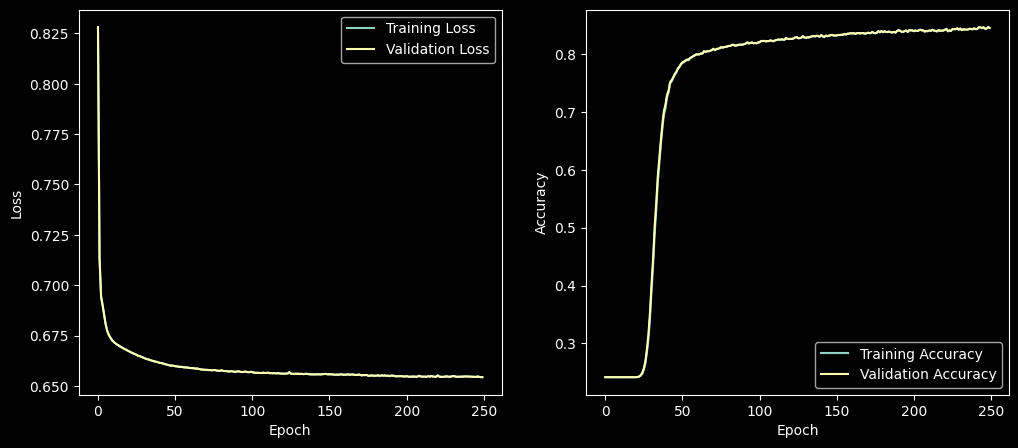

In [31]:
plt.figure(figsize=(12, 5))

#Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [32]:
def evaluate_model(model, iterator):
    all_predictions = []
    all_labels = []

    for batch in tqdm(iterator):
        predictions = model(batch.text).squeeze(1)
        all_predictions += predictions.tolist()
        all_labels += batch.label.tolist()

    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)

    y_pred_binary = torch.round(torch.sigmoid(all_predictions)).cpu().numpy()
    y_true = all_labels.cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, all_predictions.cpu().numpy())

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)

    fpr, tpr, _ = roc_curve(y_true, all_predictions.cpu().numpy())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 153/153 [00:00<00:00, 1100.71it/s]


Accuracy: 0.8184998906625848
F1 Score: 0.5640756302521007
ROC AUC Score: 0.7713222858223432


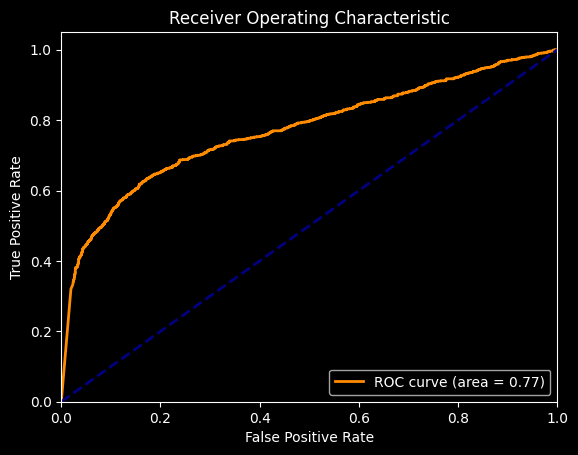

In [33]:
evaluate_model(model_gru, test_iterator)